#Energy Analysis Residential Home

We are considerig alternative energy supply options to lower the electricity bill and to sustain our household during power outages.  The electrical supply in South Africa is managed poorly and we experience regular scheduled power cuts, politely called "Load Scheduling".

The electrical energy consumption in my home was measured since June 6 until June 28 (today), a little less than a month.  We do not (yet) have solar water warming, instead using electrical heating.  June is a winter month, so we tend to use heaters on some cold evenings, if the wood fire is not burning.  BTW wood is even less sustainable than electrical energy supply sources.

This document is still in process. When complete I would like to come to some conclusion on how far to go with photovoltaic (PV) alternative energy.  One aspect that is quite clear at the moment is that the final decision is a highly personnal matter - different people have diffent needs and value systems - and ultimately different truths.





In [157]:
import numpy as np
import scipy as sp
import pandas as pd
import pyradi.ryplot as ryplot
import os.path
from scipy.optimize import curve_fit
import datetime
from dateutil.parser import parse

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

import pyradi.ryplot as ryplot
# import pyradi.ryplanck as ryplanck
# import pyradi.ryfiles as ryfiles
# import pyradi.rymodtran as rymodtran

# import xlsxwriter

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

#make pngs at 150 dpi
import matplotlib as mpl
mpl.rc("savefig", dpi=150)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)

#Energy analysis

We have an [Engage Efergy](http://efergy.com/uk/products/engage-hub-kit) monitor sample the electricity use at 1-minute intervals.  This section analyses our energy use during three weeks in the month of June.

Read the file and form a few new columns from the existing data.  The data in the file is given in units of Watt-minutes.

In [176]:
filename = 'data/201506-efergy.csv'
df = pd.read_csv(filename)
df.columns = ['DateTime','Wm']
#remove all (emty) lines with NaN values
df = df[df.Wm.notnull()]
#calc the energy in kWh
df['kWm'] = df['Wm'] / 1000.
df['kWh'] = df['Wm'] * 60. / 1000.
#convert from string to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])
# set index to be the date-time
df = df.set_index('DateTime')

# print(df.index[7830])
# print(df['2015-06-06'])
# print(df['2015-06-06 11'])

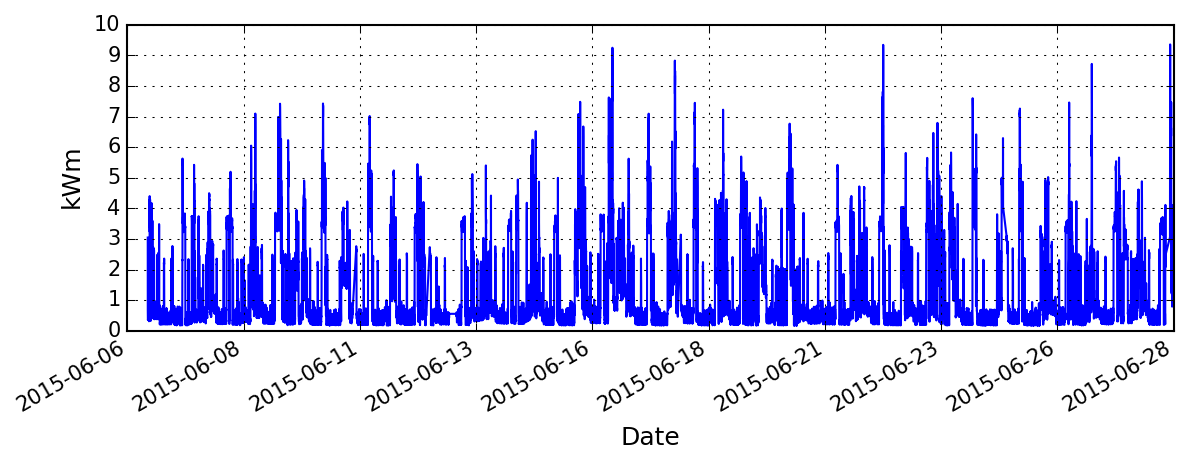

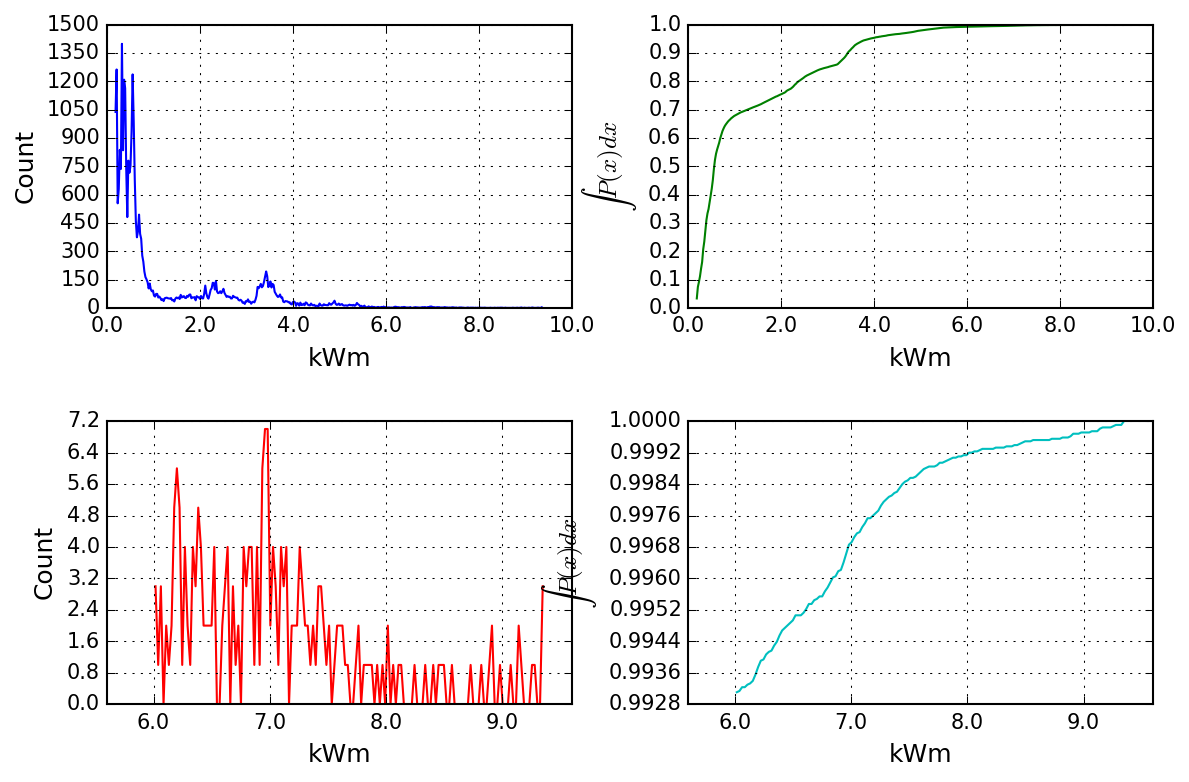

In [177]:
p = ryplot.Plotter(1,1,1, figsize=(9,3));
p.plot(1, df.index.values, df['kWm'],'','Date','kWm',xIsDate=True,xtickRotation=30);

q = ryplot.Plotter(2,2,2, figsize=(9,6));
hst, bins = np.histogram(df['kWm'],bins=400,density=False)
binc = (bins[1:]+bins[:-1])/2
sumHist = np.cumsum(hst).astype(np.float)
select = (binc >= 6)
sumUpToSelect = np.sum(hst[binc < 6])
q.plot(1, binc, hst,'','kWm','Count', maxNX=5);
q.plot(2, binc, sumHist/sumHist[-1],'','kWm','$\int P(x)dx$', maxNX=5);
q.plot(3, binc[select], hst[select], '','kWm','Count', maxNX=5);
q.plot(4, binc[select], (sumUpToSelect + np.cumsum(hst[select]))/sumHist[-1],'','kWm','$\int P(x) dx$', maxNX=5);


Next we consider the run lengths vs power levels. The graph shows the number of times (y-axis) that the labelled power use setting was maintained for the times shown on the x-axis.    Note that the graph is truncated on both axes, the data continues beyond the limits shown here.  

Note that the shortest measurement time in one minute, so this graph should be interpreted as a one-minute slot where the power level did occur, even if only for a faction of a second.

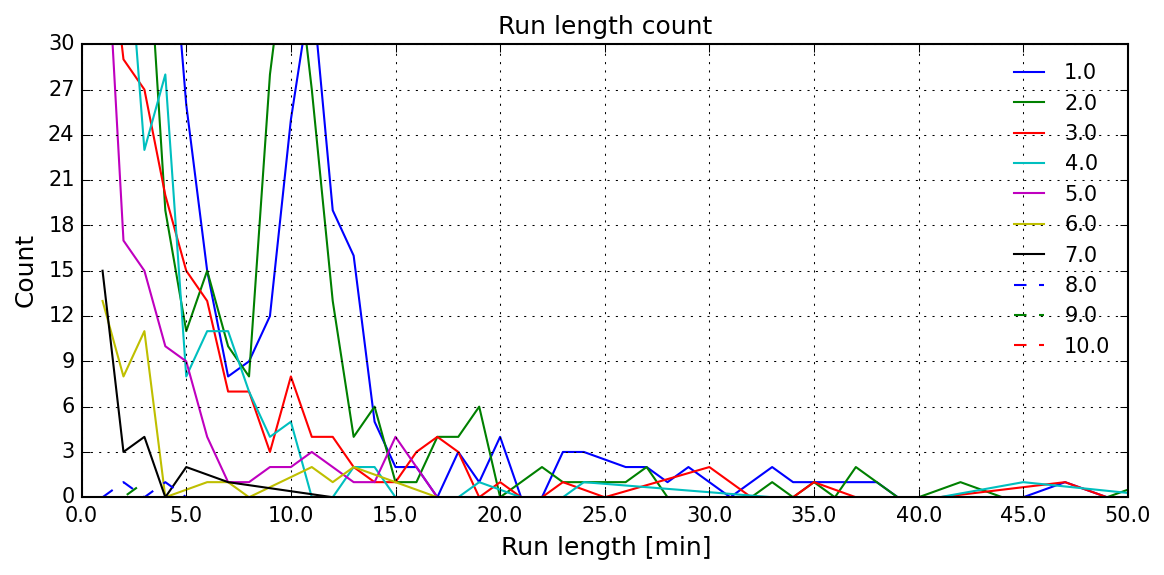

In [275]:
# https://github.com/pydata/pandas/issues/5494
# df = pd.DataFrame({"A": [1,1,2,3,2,2,3], "B": [1]*7})
# df.groupby((df.A != df.A.shift()).cumsum())["B"].sum()

dft = df
dft['1'] = np.ones(dft.kWm.shape)
thrs = np.linspace(0., 10, 11)

p = ryplot.Plotter(1,1,1, figsize=(9,4));
for thr in thrs[1:]:
    dft['thr'] = np.where(dft['kWm']>thr, 1, 0)
    # dft['Run'] = dft.groupby('thr')['1'].sum()
    # a = dft.groupby('thr')['1'].sum()

    #look for changes
    dft['Change'] = (dft.thr != dft.thr.shift())
    #count the runlength in each change
    dft['ChangeSum'] = (dft.thr != dft.thr.shift()).cumsum()
    #select only the runs above threshold
    select = (dft['thr'] == 1)
    #count the lengths of each and all runs
    rcnt = dft.ChangeSum[select].value_counts()
    runs = rcnt.value_counts().sort_index() - 1

    p.plot(1, runs.index.values, runs.values,'Run length count','Run length [min]','Count', 
           label=['{}'.format(thr)], pltaxis=[0,50, 0, 30]);
